In [1]:
"""
source: https://github.com/LauraGomezNavarro/OceanParcels_Lyapunov/blob/main/code/FTLE_func_test.py
Author: Main code by Laura Gomez Navarro adapted by Darshika Manral
"""
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import xarray as xr
import numpy.linalg as LA
from datetime import timedelta, date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from progressbar import progressbar
import multiprocessing
import sys
from scipy import stats


In [2]:
model_mask_file = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values

In [3]:
home_folder = '/nethome/manra003/analysis/dispersion/'
mon_name ='Dec'
year=2017
r_depth=0
status=0
if status == 0:
    s = '2D'
elif status == 1:
    s = '3D'

asc_order='Bkwd'

# ds=xr.open_zarr('/nethome/manra003/analysis/dispersion/simulations/Test_Bkwd_2D_Benguela_0625_401x257_Dec01-31_2017_0z.zarr')
# Bkwd_2D_Benguela_1601x1025_Dec01-31_2017_0z.zarr
ds = xr.open_zarr(home_folder + 'simulations/{0}_{1}_Benguela_1601x1025_{2}01-31_{3}_{4}z.zarr'.format(asc_order, s, mon_name, year, r_depth))

ds

<xarray.Dataset>
Dimensions:     (trajectory: 1153714, obs: 31)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 1153710 1153711 1153712 1153713
Data variables:
    lat         (trajectory, obs) float64 dask.array<chunksize=(1153714, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 dask.array<chunksize=(1153714, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(1153714, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 dask.array<chunksize=(1153714, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.4.1-265-g9573623b

In [4]:
def ftle_brunton_2009(J, Td):  # http://cwrowley.princeton.edu/papers/BruntonChaos09.pdf
    D = np.dot(np.transpose(J), J)  # Cauchy–Green strain tensor
    lamda = LA.eigvals(D)
    lam_max = max(lamda)
    ftle = (1 / Td) * np.log(np.sqrt(lam_max))
    return ftle


def dist_pairs_km(inlon1, inlon2, inlat1, inlat2):
    """
    source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

    """
    # approximate radius of earth in km
    R = 6373.0

    lon1 = radians(inlon1)
    lat1 = radians(inlat1)
    lon2 = radians(inlon2)
    lat2 = radians(inlat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [7]:
def reshape_locations(loc, mask):
    reshaped_array = np.empty((mask.shape))  # Create an empty 2D array
    reshaped_array[:]=np.NAN
    
    # Iterate through the mask and assign locations to reshaped array
    index = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j]:
                reshaped_array[i][j] = loc[index]
                index += 1
    
    return reshaped_array

In [9]:
Td=15
output_folder = home_folder+ 'outputs/ftle/'
mask_ds=np.load('/nethome/manra003/analysis/dispersion/Benguela_cropped_boolmask_1601x1025.npz') #129x65
mask=mask_ds['mask']
out_index = Td # output everyday

# initial position
x0 = reshape_locations(ds['lon'][:, 0].values, mask)
y0 = reshape_locations(ds['lat'][:, 0].values, mask)

# final position
x1 = reshape_locations(ds['lon'][:, out_index].values, mask)
y1 = reshape_locations(ds['lat'][:, out_index].values, mask)

H = x0.shape[0]
L = x1.shape[1]

FTLE_f = np.ones_like(np.asarray(x0))
FTLE_f[:,:] = np.NaN

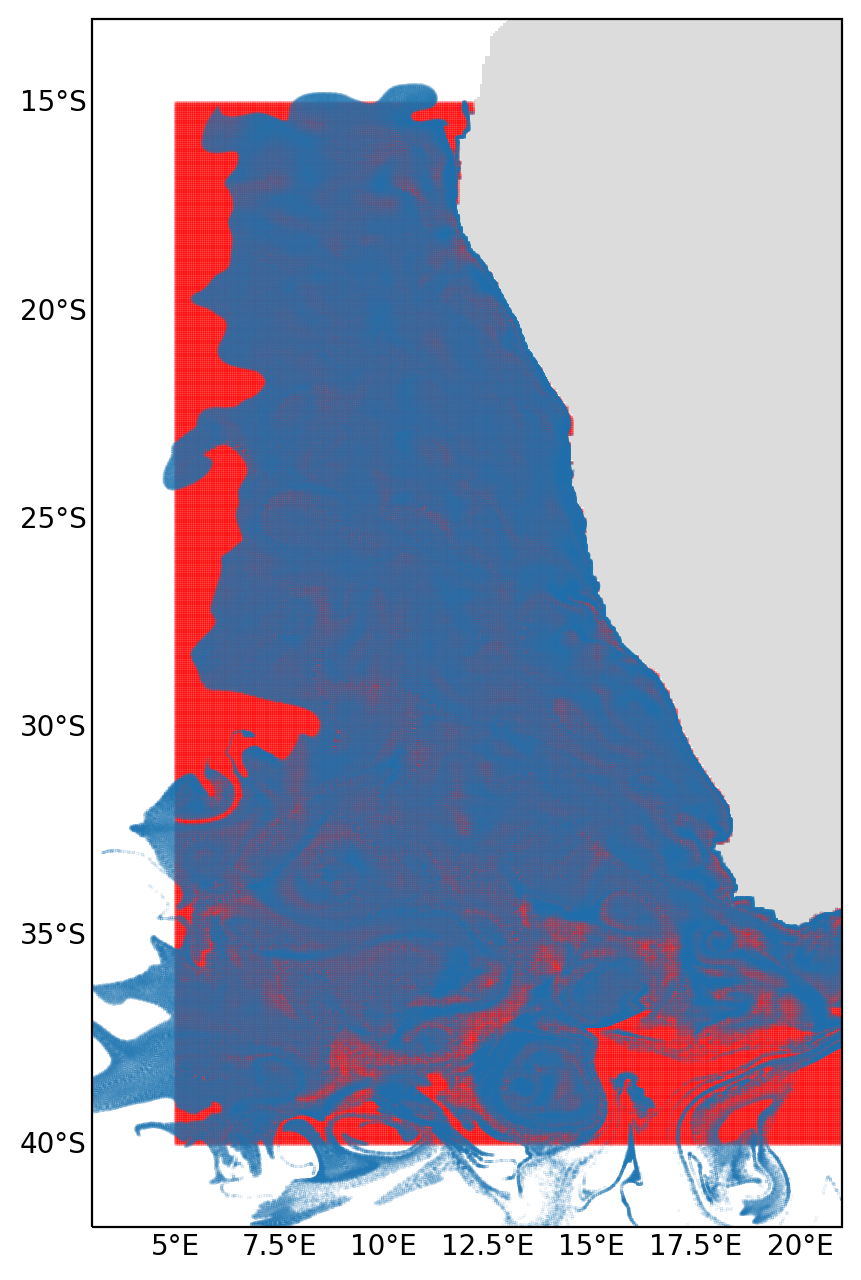

In [12]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}

colormap = colors.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(3,21)
ax.set_ylim(-42,-13)
# ax.set_xlim(16.5,18.5)
# ax.set_ylim(-32.5,-29.5)
ax.scatter(x0, y0, s=0.001, c='red')
ax.scatter(x1, y1, s=0.001)

plt.show()

In [14]:
J = np.empty([2, 2], float)

# 1, H-1 --> to ignore bordersx for now
for i in progressbar(range(1, H - 1)):  # 0, H-2
    for j in range(1, L - 1):  # 0, L-2
        # pool = multiprocessing.Pool()
        # pool = multiprocessing.Pool(processes=8)
        
        J [:,:] = np.NaN
        ls = np.array((x0[i, j], y0[i, j], 
                    x0[i - 1, j], y0[i - 1, j], 
                    x0[i, j - 1], y0[i, j - 1],
                    x0[i, j + 1], y0[i, j + 1],
                    x0[i + 1, j], y0[i + 1, j],
                    x1[i, j], y1[i, j], 
                    x1[i - 1, j], y1[i - 1, j], 
                    x1[i, j - 1], y1[i, j - 1],
                    x1[i, j + 1], y1[i, j + 1],
                    x1[i + 1, j], y1[i + 1, j]))
        if np.isnan(ls).any():
            continue

        J[0][0] = dist_pairs_km(x1[i, j], x1[i - 1, j], y1[i, j], y1[i - 1, j]) / dist_pairs_km(x0[i, j], x0[i - 1, j],
                                                                                                y0[i, j], y0[i - 1, j])
        J[0][1] = dist_pairs_km(x1[i, j], x1[i, j - 1], y1[i, j], y1[i, j - 1]) / dist_pairs_km(x0[i, j], x0[i, j - 1],
                                                                                                y0[i, j], y0[i, j - 1])
        J[1][0] = dist_pairs_km(x1[i, j], x1[i, j + 1], y1[i, j], y1[i, j + 1]) / dist_pairs_km(x0[i, j], x0[i, j + 1],
                                                                                                y0[i, j], y0[i, j + 1])
        J[1][1] = dist_pairs_km(x1[i, j], x1[i + 1, j], y1[i, j], y1[i + 1, j]) / dist_pairs_km(x0[i, j], x0[i + 1, j],
                                                                                                y0[i, j], y0[i + 1, j])
        f_value = ftle_brunton_2009(J, Td)
        FTLE_f[i][j] = f_value
print(np.nanmin(FTLE_f), np.nanmax(FTLE_f))


 23% (372 of 1599) |####                 | Elapsed Time: 0:00:39 ETA:   0:02:10

all one:  18.40625 -34.203125


 29% (466 of 1599) |######               | Elapsed Time: 0:00:48 ETA:   0:01:57

all one:  17.96875 -32.734375


100% (1599 of 1599) |####################| Elapsed Time: 0:02:16 Time:  0:02:16


-0.14292955627954193 0.429514075351728


In [16]:
#Export the FTLE to output file
output_folder = home_folder+ 'outputs/ftle/'
savename = output_folder + '{0}_{1}_Benguela_1601x1025_{2}01-31_{3}_{4}z.npz'.format(s,asc_order,mon_name, year, r_depth)

np.savez(savename, FTLE_f=FTLE_f)

In [4]:
output_folder = home_folder+ 'outputs/ftle/'
savename = output_folder + '{0}_{1}_Benguela_1601x1025_{2}01-31_{3}_{4}z.npz'.format(s,asc_order,mon_name, year, r_depth)
ftle_ds=np.load(savename)
FTLE_f=ftle_ds['FTLE_f']

In [5]:
FTLE_f.shape

(1601, 1025)

In [10]:
FTLE_f[FTLE_f<0]=np.NaN

def convert_ftle_dataset(FTLE_f):
    x0 = reshape_locations(ds['lon'][:, 0].values, mask)
    y0 = reshape_locations(ds['lat'][:, 0].values, mask)
    f= FTLE_f

    modified_ds = xr.Dataset(
        data_vars=dict(
            FTLE_f=(["x", "y"], f)
        ),
        coords=dict(
            lon=(["x", "y"], x0),
            lat=(["x", "y"], y0)
        ),
        attrs=dict(description="FTLE field"),
    )
    return modified_ds
def crop_dataset(modified_ds):
    left_lon = 10
    right_lon = 20
    top_lat = -20
    bottom_lat = -35
    ds_cropped = modified_ds.where((modified_ds.lat>bottom_lat) & (modified_ds.lat<top_lat) & (modified_ds.lon>left_lon) & (modified_ds.lon<right_lon), drop=True)
    return ds_cropped

ds_1 = convert_ftle_dataset(FTLE_f)
cropped_ds_1 = crop_dataset(ds_1)
FTLE_1=cropped_ds_1['FTLE_f']
print(np.nanmin(FTLE_1), np.nanmax(FTLE_1))

4.760925595570322e-07 0.3886343638302167


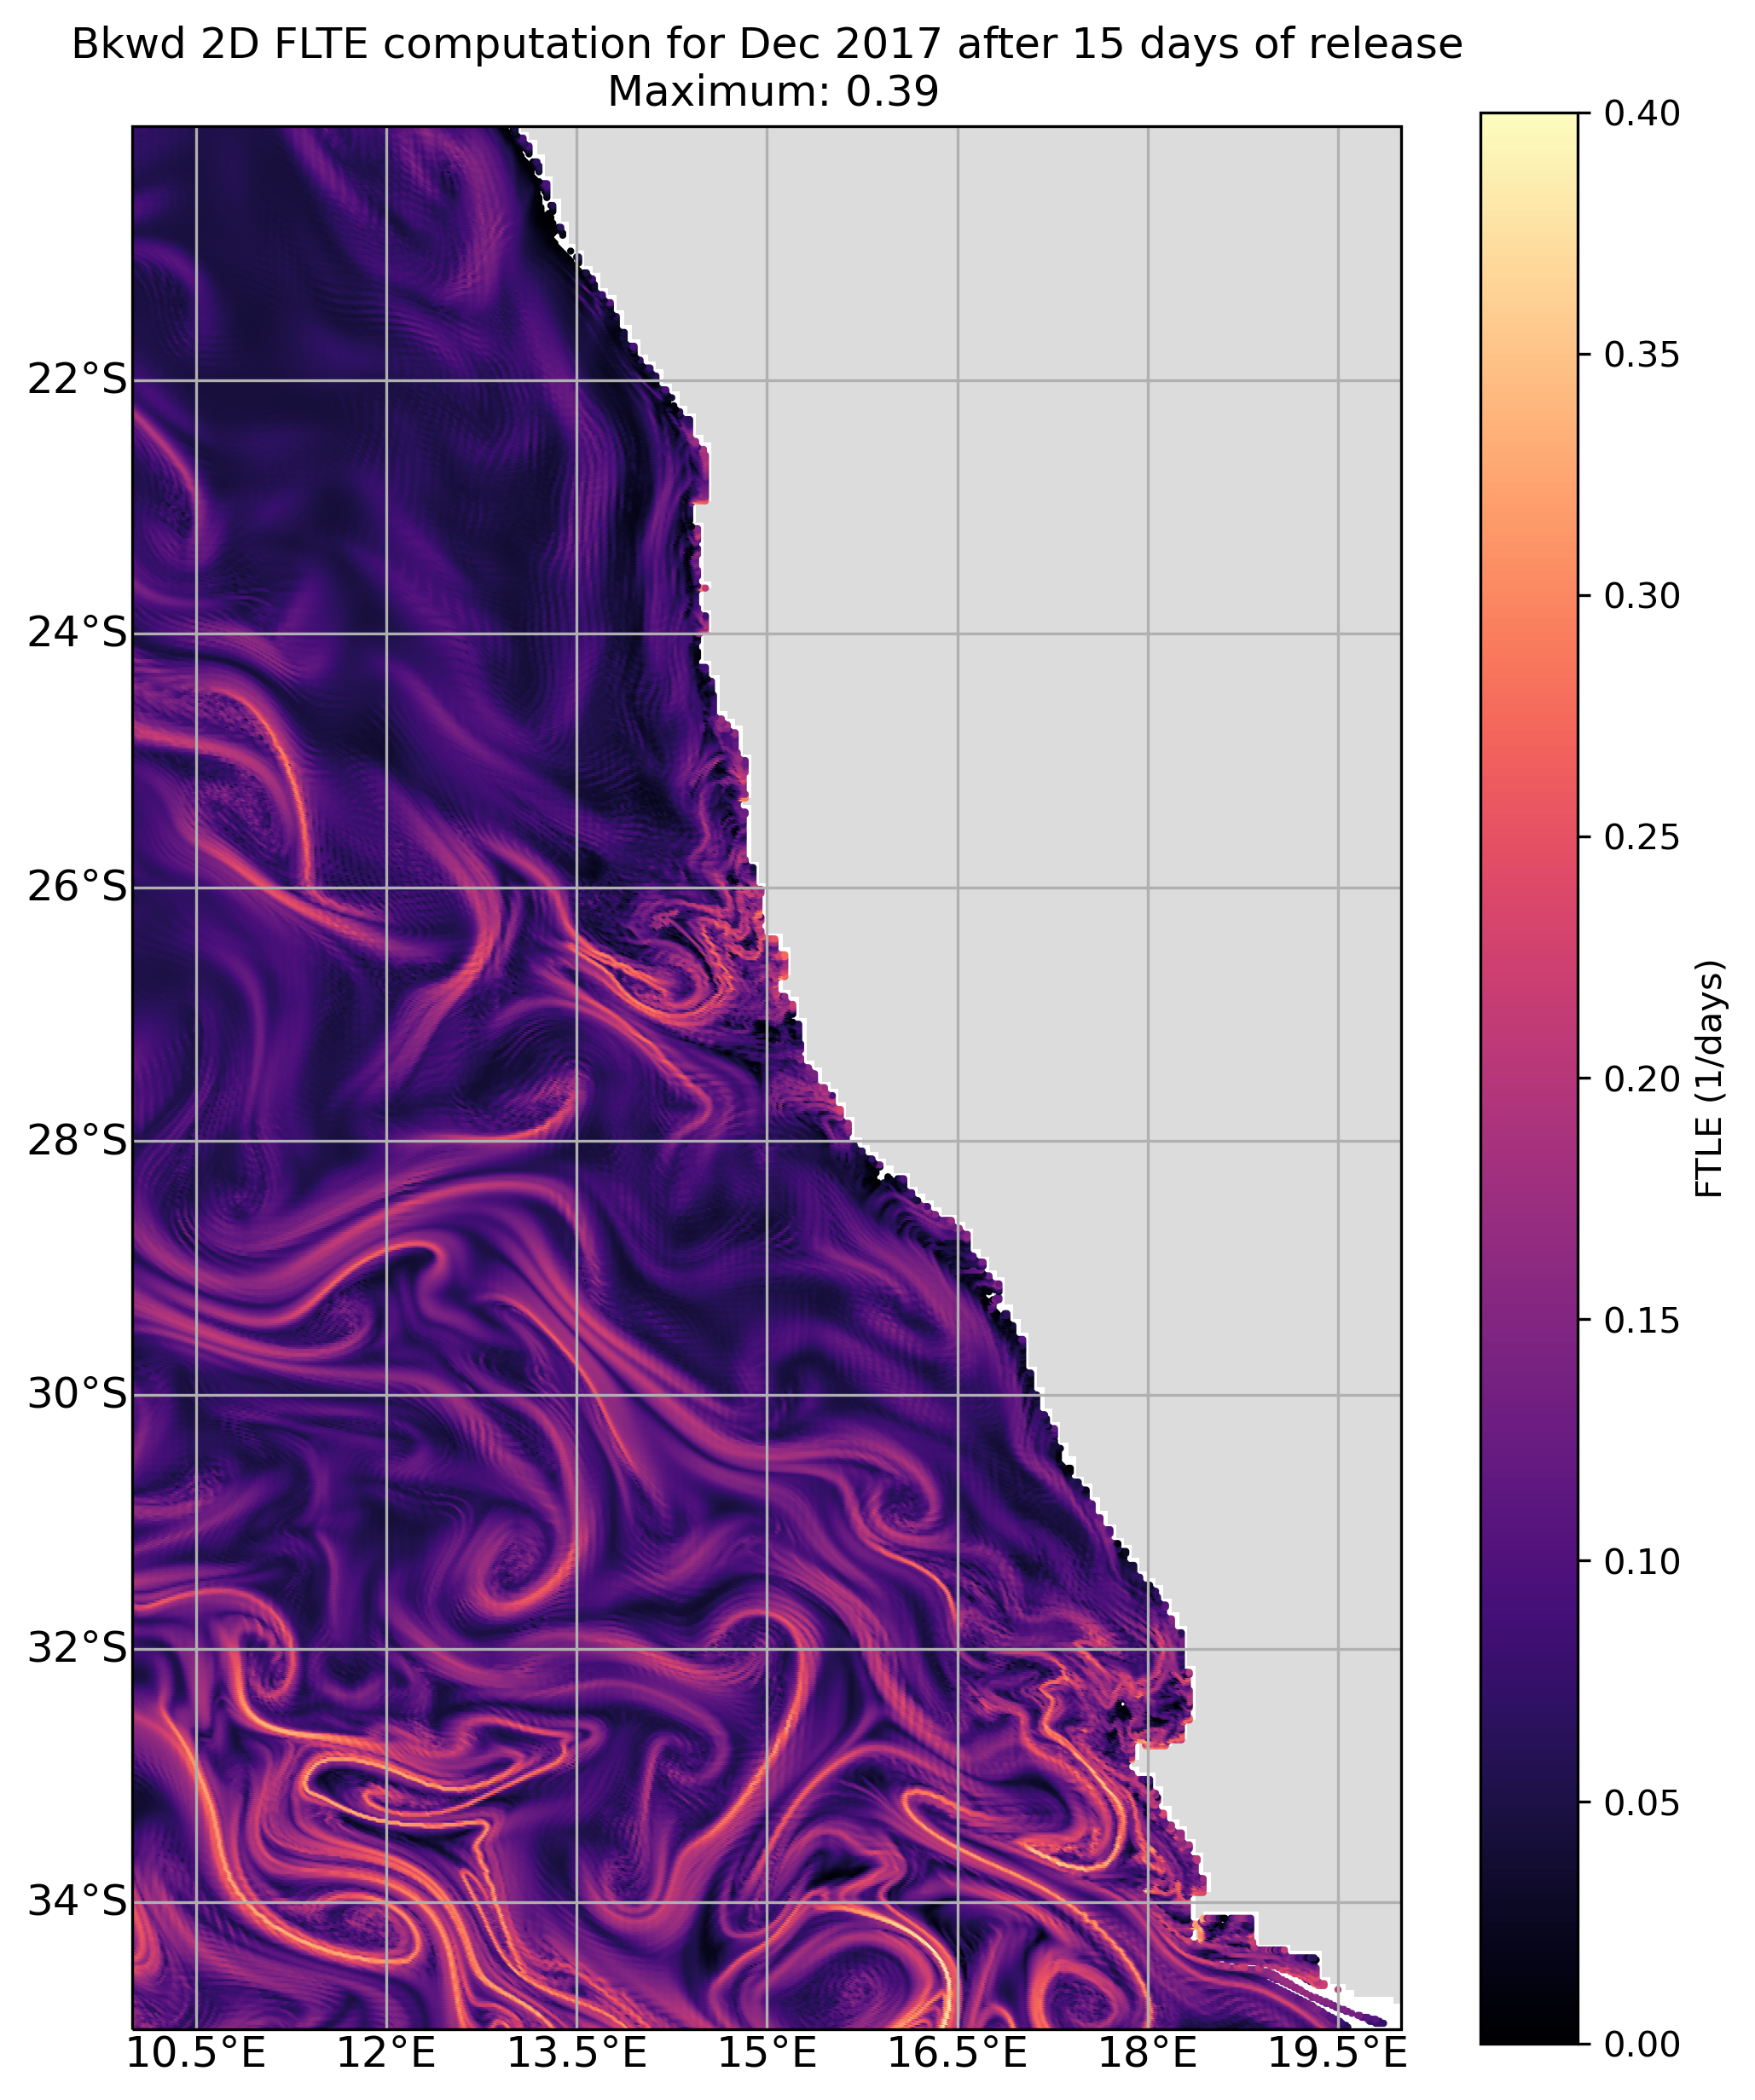

In [24]:
custom_size=12
fig = plt.figure(figsize=(8,10), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
# gl.xlines = False
# gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
ax.set_xlim(10, 20)
ax.set_ylim(-35, -20)


colormap = colors.ListedColormap(['gainsboro', 'white'])
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 0, 1250:1750, 1500:], cmap=colormap)

plt.scatter(cropped_ds_1['lon'], cropped_ds_1['lat'], c=FTLE_1, cmap='magma', s=1) #, norm=colors.LogNorm(vmax=0.4))

plt.title('{6} {5} FLTE computation for {0} {1} after {4} days of release\n Maximum: {3}'.format(mon_name, year, np.round(np.nanmin(FTLE_1),2), np.round(np.nanmax(FTLE_1),2), Td, s, asc_order))
cbar = plt.colorbar()
cbar.set_label("FTLE (1/days)")
plt.clim(0, 0.4)

plt.savefig(output_folder + '{0}_{1}_Benguela_1601x1025_{2}01-31_{3}_{4}z.jpeg'.format(s,asc_order,mon_name, year, r_depth))


DescribeResult(nobs=366162, minmax=(masked_array(data=4.7609256e-07,
             mask=False,
       fill_value=1e+20), masked_array(data=0.38863436,
             mask=False,
       fill_value=1e+20)), mean=0.10258128548931082, variance=0.002694966022643905, skewness=masked_array(data=1.28140212,
             mask=False,
       fill_value=1e+20), kurtosis=1.8703631323895769)


(array([2.1940e+03, 4.1033e+04, 9.9913e+04, 8.0420e+04, 5.1922e+04,
        3.6244e+04, 2.2878e+04, 1.4489e+04, 7.4320e+03, 4.3880e+03,
        2.6050e+03, 1.5940e+03, 8.3700e+02, 1.1800e+02, 9.5000e+01]),
 array([4.76092560e-07, 2.59094019e-02, 5.18183278e-02, 7.77272536e-02,
        1.03636179e-01, 1.29545105e-01, 1.55454031e-01, 1.81362957e-01,
        2.07271883e-01, 2.33180809e-01, 2.59089735e-01, 2.84998660e-01,
        3.10907586e-01, 3.36816512e-01, 3.62725438e-01, 3.88634364e-01]),
 <BarContainer object of 15 artists>)

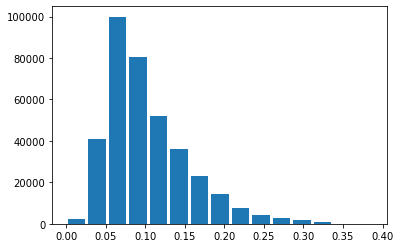

In [44]:
print(stats.describe(cropped_ds_1['FTLE_f'], axis= None, nan_policy='omit'))

plt.hist(cropped_ds_1['FTLE_f'].values.ravel(), bins=15, rwidth=0.85)